In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# This notebook will discuss a mock small-loan eligibility problem: 
## I'm going to apply classification machine learning models to determine whether accounts will qualify for small loans. Based only on their bank transaction data.

Steps:
1. Process/transform/clean and visualize raw data. 

2. Feature engineering: Select Features based on objective: Predict loan eligibility based on bank transaction data. Define 'loan_eligibility' based on rules and thresholds.

3. Exploratory Data Analysis / Data Visualization: Histograms, box plots, and scatter plots to understand feature distributions and relationships. Correlation Analysis: Identify correlations between features and target variable (Descriptive Statistics: Summary statistics of the features.)

4. Select ML model. (e.g., Logistic Regression, Decision Trees, Random Forests, Gradient Boosting, SVM, Neural Networks). Prepare data by splitting into training and testing. (80% train, 20% test). Hyperparameter Tuning: Use techniques like Grid Search or Random Search for hyperparameter optimization.

5. Model Evaluation: Accuracy, Precision, Recall, F1 Score, ROC-AUC. Model evaluation and Model Comparison

6. Interpretation

# <font color='purple'>Step 1.</font>

In [2]:
#Data pre processing: ....copied from before
transactions = pd.read_parquet("data_science_take_home_transactions.parquet", engine='pyarrow')

transactions['account_id_string'] = transactions['account_id'].copy()
label_encoder = LabelEncoder() # Create a label encoder object
transactions['account_id'] = label_encoder.fit_transform(transactions['account_id']) 
# Transform 'account_id' column to numerical values and replace the original column 

In [3]:
selected_columns = ['account_id', 'f0_', 'date']
cleaned_data = transactions.loc[:, selected_columns]

# Ensure the date column is in datetime format
cleaned_data['date'] = pd.to_datetime(cleaned_data['date'])

# Assuming cleaned_data is your DataFrame
cleaned_data = cleaned_data.sort_values(by='account_id')

num_unique_accounts = cleaned_data['account_id'].nunique()
print(f"Number of unique account_id: {num_unique_accounts}")

# Display the sorted DataFrame
cleaned_data

Number of unique account_id: 1904


,account_id,f0_,date
935972,0,-25.00,2022-02-27
1009967,0,-379.00,2022-04-27
1009968,0,-2.00,2022-11-11
1009969,0,331.68,2022-11-08
1009970,0,-222.00,2022-02-01
...,...,...,...
1202814,1903,-39.95,2022-06-13
1202815,1903,-50.00,2022-02-14
1202816,1903,-8.79,2022-08-17
1202803,1903,-29.61,2022-08-05



## Lets check what the data looks like. Any outliers?

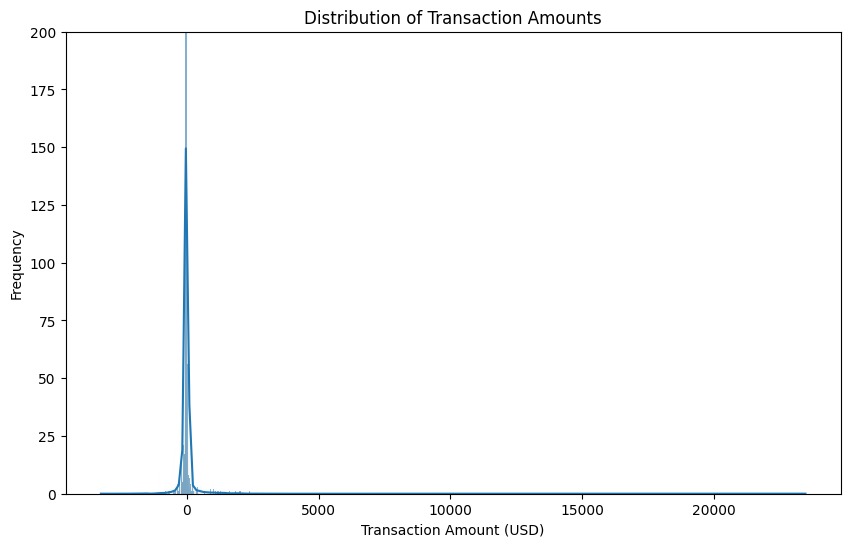

In [54]:
# Sample data for faster visualization
sample_size = 10000  # Adjust the sample size as needed
cleaned_data_sample = cleaned_data.sample(sample_size, random_state=42)

# Distribution of Transactions
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_data_sample['f0_'], kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount (USD)')
plt.ylabel('Frequency')
plt.ylim(0,200)
plt.show()

# <font color='purple'>Step 2.</font>
## Feature engineering:

features:

1. Age of account: the more data we have, the more accurate machine learning models. 

2. Average monthly balance Sum total tranasactions each month, then average over the total months.

3. Average weekly balance: Sum total tranasactions each month, then average over the total weeks.

4. Number of months where deposits exceed witdrawls i.e net positive (normalize by dividing by number of months account has been active.)

5. Average amount by which withdrawals exceed deposits: for months of net positive transaction: average by how much. (normalize by dividing by number of months).

6. Number of weeks where deposits exceed witdrawls i.e net positive (normalize by dividing by number of weeks account has been active.)

7. Average amount by which withdrawals exceed deposits: for weeks of net positive transaction: average by how much.

(more possibilities but for the sake of this exsersize i will stop here).

Now, becuase this is a "mock excersise" I will loosly choose cut-offs for these features based on some personal intuition. But in reality these cut offs would be given to me. Another variable dont being discussed here is how big of a loan I'm leanding. 

The reason we do month and week here is to capture behaviors over different times-ranges since behaviors might vary based on time of month etc. We could possibly include daily and bi-weekly behaviors but I would have to think more about this case. Could possibly add a time-series lag feature to improve accuracy further.

1. I will choose to a minimum of 3 months of transactional data. This is probably a very low number. but for small loans it might be enough. Especially in an experimental phase becuase the more loans I hand out, the more costumers/data I will attain. Being prepared to loose some money.

2. To offer someone a loan based on their transactional data I would like them to keep their account at a net positive. Say, save at least USD20 a month. Assuming a lot of these accounts are people living paycheck-to-paycheck, USD50 a month on average is probably ok. 

3. If monthly average is USD50, I belive weekly average can be less. Say USD30. Need to think more about this.

4. I would like the person I'm lending money to keeping a net positive in their account for the majority of months. Personally, I would set cutoff at 0.8 but this is a little strict. Lets so 0.6 since a lot of my customors are living paycheck to paycheck.

5. This is similar to 2. And may not give us too much information other than excluding months with net-negative. What it CAN tell us is how much this person saves each month, removing large spending ... maybe they put down a large down-payment for a car one month--bringing down their the total average... Therefor the amount have to be larger than USD50. I will choose USD150 becuase this is 3x the total average hence it proves this person has occasional large spendings but healthy overall saving.

6. Some people get paid per month, and some gig or bi-weekly. But most people pay rent every month. Thats why I include this feature to capture peoples weekly spending/saving habits. Let set cut-off here at 0.55. Lower than monthly. Need to think deeper about this and adjust.

7. Similar case here as in 5. Lets do USD100. Adjust later.




In [7]:
# Calculate the age of the account for each account_id
account_age = cleaned_data.groupby('account_id')['date'].agg(['min', 'max'])
account_age['account_age_days'] = (account_age['max'] - account_age['min']).dt.days
account_age['account_age_months'] = np.ceil((account_age['max'] - account_age['min']) / pd.Timedelta(days=31)).astype(int)
account_age['account_age_weeks'] = (account_age['account_age_days'] / 7).astype(int)

# Create new_data dataframe with account_id and age of account
new_data = pd.DataFrame({
    'account_id': account_age.index,
    'account_age_days': account_age['account_age_days'].values,
    'account_age_months': account_age['account_age_months'].values,
    'account_age_weeks': account_age['account_age_weeks'].values
    })

In [8]:
# montly calculations:
monthly_balance = cleaned_data.groupby(['account_id', cleaned_data['date'].dt.to_period('M')])['f0_'].sum().reset_index()
avg_monthly_balance = monthly_balance.groupby('account_id')['f0_'].mean().reset_index()
avg_monthly_balance.columns = ['account_id', 'avg_monthly_balance']
new_data = new_data.merge(avg_monthly_balance, on='account_id', how='left')
monthly_balance = cleaned_data.groupby(['account_id', cleaned_data['date'].dt.to_period('M')])['f0_'].sum().reset_index()
monthly_balance['net_positive_month'] = monthly_balance['f0_'] > 0
num_net_positive_months = monthly_balance.groupby('account_id')['net_positive_month'].sum().reset_index()
num_net_positive_months.columns = ['account_id', 'num_net_positive_months']
new_data = new_data.merge(num_net_positive_months, on='account_id', how='left')
new_data['norm_num_net_positive_months'] = new_data['num_net_positive_months'] / new_data['account_age_months']
monthly_balance = cleaned_data.groupby(['account_id', cleaned_data['date'].dt.to_period('M')])['f0_'].sum().reset_index()
monthly_balance['net_positive_month'] = monthly_balance['f0_'] > 0
monthly_balance_positive = monthly_balance[monthly_balance['net_positive_month']]
avg_monthly_positive = monthly_balance_positive.groupby('account_id')['f0_'].mean().reset_index()
avg_monthly_positive.columns = ['account_id', 'avg_monthly_positive']
new_data = new_data.merge(avg_monthly_positive, on='account_id', how='left')

In [9]:
#weekly calculations:
# Calculate Average Weekly Balance from cleaned_data
weekly_balance = cleaned_data.groupby(['account_id', cleaned_data['date'].dt.to_period('W')])['f0_'].sum().reset_index()
avg_weekly_balance = weekly_balance.groupby('account_id')['f0_'].mean().reset_index()
avg_weekly_balance.columns = ['account_id', 'avg_weekly_balance']
new_data = new_data.merge(avg_weekly_balance, on='account_id', how='left')
weekly_balance = cleaned_data.groupby(['account_id', cleaned_data['date'].dt.to_period('W')])['f0_'].sum().reset_index()
weekly_balance['net_positive_week'] = weekly_balance['f0_'] > 0
num_net_positive_weeks = weekly_balance.groupby('account_id')['net_positive_week'].sum().reset_index()
num_net_positive_weeks.columns = ['account_id', 'num_net_positive_weeks']
new_data = new_data.merge(num_net_positive_weeks, on='account_id', how='left')
new_data['norm_num_net_positive_weeks'] = new_data['num_net_positive_weeks'] / (new_data['account_age_weeks'])  
weekly_balance = cleaned_data.groupby(['account_id', cleaned_data['date'].dt.to_period('W')])['f0_'].sum().reset_index()
weekly_balance['net_positive_week'] = weekly_balance['f0_'] > 0
weekly_balance_positive = weekly_balance[weekly_balance['net_positive_week']]
avg_weekly_positive = weekly_balance_positive.groupby('account_id')['f0_'].mean().reset_index()
avg_weekly_positive.columns = ['account_id', 'avg_weekly_positive']

In [17]:
# Merge into new_data dataframe
new_data = new_data.merge(avg_weekly_positive, on='account_id', how='left')
# Display new_data with added column


#Remove infinity values/NaN -- set NaN = 0 which is ok in this case.

new_data = new_data.fillna(0)
new_data.replace([np.inf, -np.inf], 0, inplace=True)

feature_columns = ['account_age_months', # 1. Age of account
                   'avg_monthly_balance', #2. Average monthly balance
                   'avg_weekly_balance', #3. Average weekly balance
                   'norm_num_net_positive_months', # 4. Number of months where deposits exceed witdrawls. Normalized
                   'avg_monthly_positive', # 5. Monthly average amount by which withdrawals exceed deposits. Normalized
                   'norm_num_net_positive_weeks', # 6. Number of weeks where deposits exceed witdrawls. Normalized
                   'avg_weekly_positive'] # 7. Weekly average amount by which withdrawals exceed deposits. Normalized

new_data['loan_eligibility'] = (
    (new_data['account_age_months'] > 5 &
    (new_data['avg_monthly_balance'] > 50) & 
    (new_data['avg_weekly_balance'] > 30) & 
    (new_data['norm_num_net_positive_months'] > 0.8) & 
    (new_data['avg_monthly_positive'] > 250) & 
    (new_data['norm_num_net_positive_weeks'] > 0.7) & 
    (new_data['avg_weekly_positive'] > 100)).astype(int)
)
new_data

,account_id,account_age_days,account_age_months,account_age_weeks,avg_monthly_balance,num_net_positive_months,norm_num_net_positive_months,avg_monthly_positive,avg_weekly_balance,num_net_positive_weeks,norm_num_net_positive_weeks,avg_weekly_positive_x,loan_eligibility,avg_weekly_positive_y,avg_weekly_positive
0,0,425,14,60,25.608667,8,0.571429,327.706250,6.402167,29,0.483333,89.202759,1,89.202759,89.202759
1,1,51,2,7,179.785000,2,1.000000,179.785000,44.946250,6,0.857143,726.298333,1,726.298333,726.298333
2,2,424,14,60,-99.181333,3,0.214286,1113.740000,-23.995484,28,0.466667,653.506429,1,653.506429,653.506429
3,3,413,14,59,126.577333,10,0.714286,458.841000,34.521091,31,0.525424,355.669355,1,355.669355,355.669355
4,4,142,5,20,7.726000,3,0.600000,452.896667,2.971538,6,0.300000,439.035000,1,439.035000,439.035000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,1899,410,14,58,3.943846,6,0.428571,423.411667,1.139333,17,0.293103,589.775882,1,589.775882,589.775882
1900,1900,423,14,60,126.000000,6,0.428571,676.471667,28.918033,32,0.533333,565.596563,1,565.596563,565.596563
1901,1901,426,14,60,-0.237143,7,0.500000,93.347143,-0.053548,29,0.483333,104.246552,1,104.246552,104.246552
1902,1902,410,14,58,19.642143,6,0.428571,114.700000,5.391961,24,0.413793,325.358750,1,325.358750,325.358750


In [53]:
# Calculate mean and standard deviation for each feature
for feature in feature_columns:
    mean_value = new_data[feature].mean()
    std_dev = new_data[feature].std()
    print(f"Feature: {feature}")
    print(f"  Mean: {mean_value:.2f}")
    print(f"  Standard Deviation: {std_dev:.2f}")
    print()



Feature: account_age_months
  Mean: 9.95
  Standard Deviation: 4.73

Feature: avg_monthly_balance
  Mean: -11.47
  Standard Deviation: 200.63

Feature: avg_weekly_balance
  Mean: -1.20
  Standard Deviation: 65.14

Feature: norm_num_net_positive_months
  Mean: 0.53
  Standard Deviation: 0.21

Feature: avg_monthly_positive
  Mean: 575.68
  Standard Deviation: 1088.86

Feature: norm_num_net_positive_weeks
  Mean: 0.48
  Standard Deviation: 0.17

Feature: avg_weekly_positive
  Mean: 524.91
  Standard Deviation: 675.24



In [40]:
feature_columns = ['account_age_months', # 1. Age of account
                   'avg_monthly_balance', #2. Average monthly balance
                   'avg_weekly_balance', #3. Average weekly balance
                   'norm_num_net_positive_months', # 4. Number of months where deposits exceed witdrawls. Normalized
                   'avg_monthly_positive', # 5. Monthly average amount by which withdrawals exceed deposits. Normalized
                   'norm_num_net_positive_weeks', # 6. Number of weeks where deposits exceed witdrawls. Normalized
                   'avg_weekly_positive'] # 7. Weekly average amount by which withdrawals exceed deposits. Normalized

# <font color='purple'>Step 3.</font>

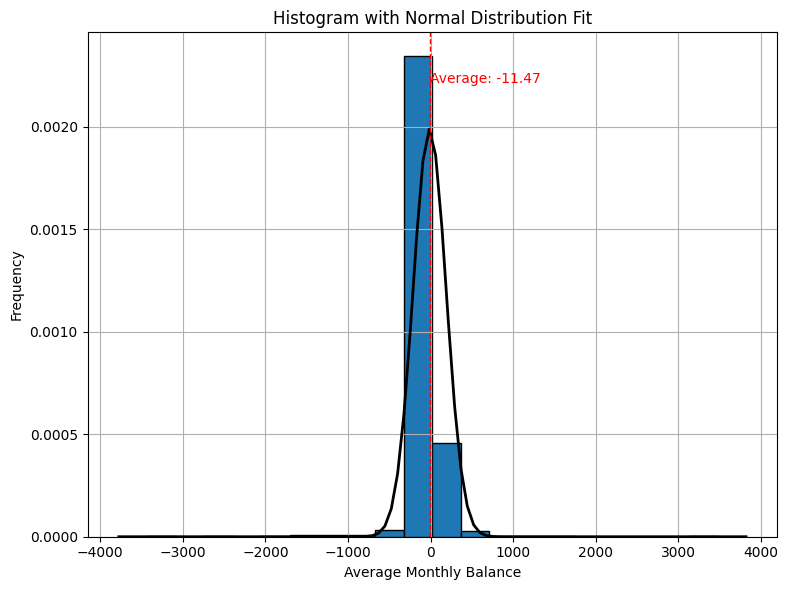

In [52]:
from scipy.stats import norm
plt.figure(figsize=(8, 6))

# Plot histogram for 'avg_monthly_balance'
plt.hist(new_data['avg_monthly_balance'], bins=20, edgecolor='black', density=True)  # density=True for normalized histogram

# Calculate mean and standard deviation
mean_balance = np.mean(new_data['avg_monthly_balance'])
std_dev = np.std(new_data['avg_monthly_balance'])

# Plot normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_balance, std_dev)
plt.plot(x, p, 'k', linewidth=2)

# Add labels and title
plt.xlabel('Average Monthly Balance')
plt.ylabel('Frequency')
plt.title('Histogram with Normal Distribution Fit')

# Add average balance label
plt.axvline(mean_balance, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_balance + 1, plt.ylim()[1] * 0.9, f'Average: {mean_balance:.2f}', color='red')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(4, 4))
plt.hist(new_data['account_age_months'], bins=20, edgecolor='black')
# Add labels and title
plt.xlabel('Account Age (Months)')
plt.ylabel('Frequency')
plt.title('Histogram of Account Age in Months')

mean_age_months = np.mean(new_data[feature_column])
# Add average age label
plt.axvline(mean_age_months, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_age_months + 1, plt.ylim()[1] * 0.9, f'Average: {mean_age_months:.2f}', color='red')
# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

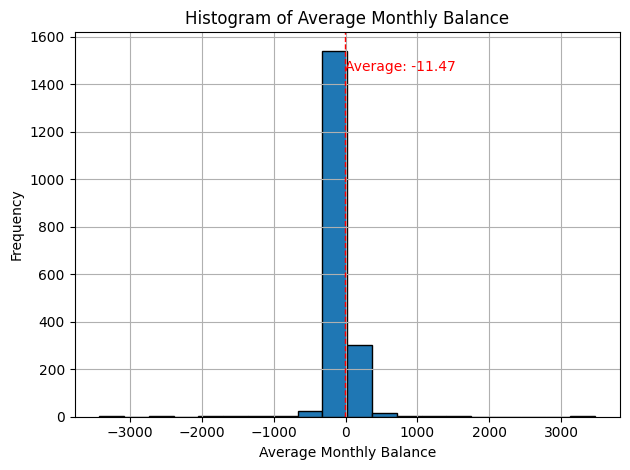

In [48]:

# Plot histogram for 'avg_monthly_balance'
plt.hist(new_data['avg_monthly_balance'], bins=20, edgecolor='black')  # Adjust bins and edgecolor as needed

# Add labels and title
plt.xlabel('Average Monthly Balance')
plt.ylabel('Frequency')
plt.title('Histogram of Average Monthly Balance')

# Add average balance label
plt.axvline(mean_monthly_balance, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_monthly_balance + 1, plt.ylim()[1] * 0.9, f'Average: {mean_monthly_balance:.2f}', color='red')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

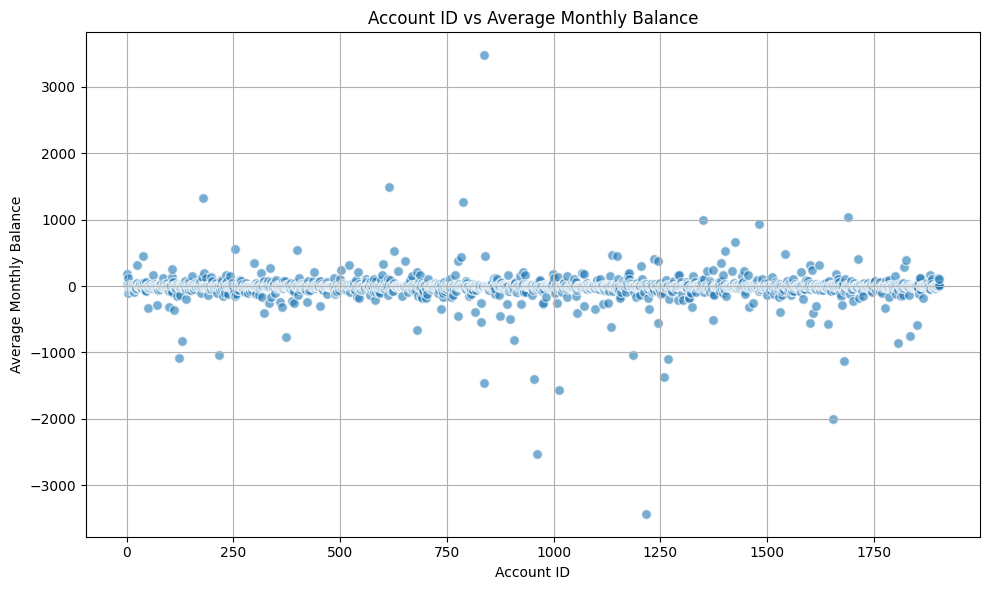

In [49]:
# Select columns for plotting
account_id = new_data['account_id']
avg_monthly_balance = new_data['avg_monthly_balance']

# Create a figure for the scatter plot
plt.figure(figsize=(10, 6))

# Plot account_id vs avg_monthly_balance
plt.scatter(account_id, avg_monthly_balance, marker='o', s=50, alpha=0.6, edgecolors='w')

# Add labels and title
plt.xlabel('Account ID')
plt.ylabel('Average Monthly Balance')
plt.title('Account ID vs Average Monthly Balance')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

# <font color='purple'>Step 4, 5 and 6.</font>
## Selecting the right model for predicting loan eligibility based on transactional data depends on several factors, including the nature of the data, the complexity of the relationships within the data, and the need for interpretability versus predictive accuracy. Here are some model options and considerations for each:

#### Logistic Regression:

Pros: Simple, interpretable, works well with a linear relationship between features and the target.
Cons: May not capture complex relationships.
Use Case: When you need a simple, interpretable model to understand the influence of each feature on loan eligibility.
Decision Trees:

Pros: Simple to understand, can capture non-linear relationships.
Cons: Can be prone to overfitting, especially with deep trees.
Use Case: When you need a model that can capture non-linear relationships but is still relatively easy to interpret.

#### Random Forest:

Pros: Reduces overfitting by averaging multiple decision trees, can handle non-linear relationships.
Cons: Less interpretable than a single decision tree.
Use Case: When you need a more robust model that can handle complex relationships and interactions.

#### Gradient Boosting Machines (e.g., XGBoost, LightGBM):

Pros: High predictive accuracy, can handle non-linear relationships and interactions, effective with large datasets.
Cons: More complex and less interpretable, requires tuning of hyperparameters.
Use Case: When predictive accuracy is the most important criterion, and you are willing to invest time in model tuning.

#### Support Vector Machines (SVM):

Pros: Effective in high-dimensional spaces, can handle non-linear relationships with the right kernel.
Cons: Computationally intensive, less interpretable.
Use Case: When you have high-dimensional data and need a powerful model to capture complex relationships.

#### Neural Networks:

Pros: Can model very complex relationships, highly flexible.
Cons: Requires a large amount of data, computationally intensive, less interpretable.
Use Case: When you have a large dataset and need to model very complex, non-linear relationships.

### I'm choosing logistic regression and random forest for its simplicity and interpretability. And random forest for a balance between interpretability and the ability to capture complex relationships.

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
X = new_data[feature_columns]
y = new_data['loan_eligibility']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## <font color='red'>Logistic Regression</font>


In [20]:
# Initialize the logistic regression model
logreg_model = LogisticRegression()

# Fit the model to the training data
logreg_model.fit(X_train, y_train)

# look into regularization, L1 vs L2

LogisticRegression()

## <font color='red'>Random Forest</font>

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
# Initialize the random forest model
rf_model = RandomForestClassifier(random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [59]:
# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Model Evaluation:
Accuracy: 0.994750656167979

Confusion Matrix:
 [[  1   2]
 [  0 378]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.99      1.00      1.00       378

    accuracy                           0.99       381
   macro avg       1.00      0.67      0.75       381
weighted avg       0.99      0.99      0.99       381



|                | Predicted Negative (0) | Predicted Positive (1) |
|----------------|------------------------|------------------------|
| Actual Negative (0) | TN                     | FP                     |
| Actual Positive (1) | FN                     | TP                     |

### Classification Report
#### Accuracy: 0.9947 (or 99.47%) means that the model correctly predicted 99.47% of the total cases.
**Precision:**

- Precision for class 0: 1.00 (or 100%): Out of all predicted positives for class 0, all are actually positive.
- Precision for class 1: 0.99 (or 99%): Out of all predicted positives for class 1, 99% are actually positive.

**Recall:**

- Recall for class 0: 0.33 (or 33%): The model correctly identified 33% of all actual class 0 instances.
- Recall for class 1: 1.00 (or 100%): The model correctly identified all (100%) of the actual class 1 instances.

**F1-score:**

- F1-score for class 0: 0.50: The harmonic mean of precision and recall for class 0.
- F1-score for class 1: 1.00: The harmonic mean of precision and recall for class 1.

**Support:**

- Support for class 0: 3 instances.
- Support for class 1: 378 instances.

**Interpretation:**

- The model shows very high accuracy (99.47%), indicating strong overall performance in predicting both classes.
- For class 0, the recall is relatively low (33%), suggesting that the model identifies only a third of the actual instances of class 0. This could be a concern if identifying all instances of class 0 is crucial.
- Precision for both classes is high, especially for class 0, indicating that when the model predicts class 0, it is very likely to be correct.
- The F1-score for class 0 is lower compared to class 1, reflecting the balance between precision and recall for each class.
- In summary, while the model performs exceptionally well in terms of accuracy and precision for class 1, the lower recall for class 0 suggests potential room for improvement, especially if identifying all instances of class 0 is critical for your application.


# <font color='purple'>Step 6.</font>

|                | Predicted Negative (0) | Predicted Positive (1) |
|----------------|------------------------|------------------------|
| Actual Negative (0) | TN                     | FP                     |
| Actual Positive (1) | FN                     | TP                     |

In [60]:
# Make predictions on the test data
y_pred = logreg_model.predict(X_test)

# Evaluate the model
print("Logistic Regression Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Logistic Regression Model Evaluation:
Accuracy: 0.9921259842519685

Confusion Matrix:
 [[  1   2]
 [  1 377]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.99      1.00      1.00       378

    accuracy                           0.99       381
   macro avg       0.75      0.67      0.70       381
weighted avg       0.99      0.99      0.99       381



- True Positives (TP): 377 (predicted positive and actually positive)
- True Negatives (TN): 1 (predicted negative and actually negative)
- False Positives (FP): 2 (predicted positive but actually negative)
- False Negatives (FN): 1 (predicted negative but actually positive)

**Interpretation:**

- **Precision:**
  - Precision for class 0: 0.50 (or 50%): Out of all predicted positives for class 0, 50% are actually positive.
  - Precision for class 1: 0.99 (or 99%): Out of all predicted positives for class 1, 99% are actually positive.

- **Recall:**
  - Recall for class 0: 0.33 (or 33%): The model correctly identified 33% of all actual class 0 instances.
  - Recall for class 1: 1.00 (or 100%): The model correctly identified all (100%) of the actual class 1 instances.

- **F1-score:**
  - F1-score for class 0: 0.40: The harmonic mean of precision and recall for class 0.
  - F1-score for class 1: 1.00: The harmonic mean of precision and recall for class 1.

- **Support:**
  - Support for class 0: 3 instances.
  - Support for class 1: 378 instances.

- The model achieves high accuracy (99.21%), indicating strong overall performance in predicting both classes.
- However, for class 0, both precision and recall are lower compared to class 1, indicating that the model's performance in identifying instances of class 0 is less reliable.
- Precision for class 0 is relatively low, meaning when the model predicts class 0, it is correct only half of the time.
- The F|1-score for class 0 is also lower compared to class 1, indicating a balance between precision and recall that could be improved, especially for class 0.
- In summary, while the model performs very well for class 1, there is room for




Random forest:

### Classification Report
#### Accuracy: 0.9947 (or 99.47%) means that the model correctly predicted 99.47% of the total cases.
**Precision:**

- Precision for class 0: 1.00 (or 100%): Out of all predicted positives for class 0, all are actually positive.
- Precision for class 1: 0.99 (or 99%): Out of all predicted positives for class 1, 99% are actually positive.

**Recall:**

- Recall for class 0: 0.33 (or 33%): The model correctly identified 33% of all actual class 0 instances.
- Recall for class 1: 1.00 (or 100%): The model correctly identified all (100%) of the actual class 1 instances.

**F1-score:**

- F1-score for class 0: 0.50: The harmonic mean of precision and recall for class 0.
- F1-score for class 1: 1.00: The harmonic mean of precision and recall for class 1.

**Support:**

- Support for class 0: 3 instances.
- Support for class 1: 378 instances.

**Interpretation:**

- The model shows very high accuracy (99.47%), indicating strong overall performance in predicting both classes.
- For class 0, the recall is relatively low (33%), suggesting that the model identifies only a third of the actual instances of class 0. This could be a concern if identifying all instances of class 0 is crucial.
- Precision for both classes is high, especially for class 0, indicating that when the model predicts class 0, it is very likely to be correct.
- The F1-score for class 0 is lower compared to class 1, reflecting the balance between precision and recall for each class.
- In summary, while the model performs exceptionally well in terms of accuracy and precision for class 1, the lower recall for class 0 suggests potential room for improvement, especially if identifying all instances of class 0 is critical for your application.
